In [1]:
# import libraries
# requires prior sign up for google earth engine: go to http://code.earthengine.google.com/
# for Python Google Earth Engine install instructions, see https://developers.google.com/earth-engine/python_install
import ee 
import datetime
import pandas as pd
ee.Initialize()

In [2]:
# get_data takes a startTime, endTime, and a location and returns emissivity, elevation, LST, NDVI, landcover
# note: using this function with a single latlon is not super efficient as it calculates the whole scene and then extracts points 
def get_data(startTime,endTime,latlon):   

    try:
    #if(True):
        ## Read in data from GEE
        #Read Landsat 8 Image
        L8_DN = ee.ImageCollection('LANDSAT/LC8_L1T').filterDate(startTime, endTime)  
        # read in emissivity and correct units
        emissivity = ee.Image('NASA/ASTER_GED/AG100_003').select('emissivity_band10').multiply(0.001) 
        # read in elevation 
        srtm = ee.Image('USGS/SRTMGL1_003')
        # read in landcover info
        impervious = ee.Image('USGS/NLCD/NLCD2011').select('impervious')
        
        ## Set up LST computation
        # computes emissivity-corrected land surface temperature given Landsat8 band 10 (tir) and emissivity
        # assumes tir, emissivity are google earth engine images
        k1 = 774.8853 ; # constants for Landsat8 B10
        k2 =  1321.0789 ; # constants for Landsat8 B10
        dummyk1 = emissivity.multiply(0).add(1).multiply(k1) # make dummy variable same size/type as emissivity
        dummyk2 = emissivity.multiply(0).add(1).multiply(k2) # make dummy variable same size/type as emissivity
        
        # initialize pandas datafrmae to store data 
        df_all = pd.DataFrame()
        
        for loc in latlon[0:95:3]:
            try:
                ## Select points
                # subset point, sorting on cloud cover
                point = {'type':'Point', 'coordinates':[loc[1],loc[0]]};
                L8_DN_point = L8_DN.filterBounds(point)    
                L8_DN_point = L8_DN_point.sort('CLOUD_COVER').first()  
                
                # select individual bands, assuming Landsat8
                image = ee.Image(L8_DN_point)
                tir = image.select(u'B10') # thermal infrared
                red = image.select(u'B4') # infrared
                nir = image.select(u'B5') # near infrared
                
                ## compute NDVI
                # for more on NDVI, see https://en.wikipedia.org/wiki/Normalized_Difference_Vegetation_Index
                ndvi = nir.subtract(red).divide(nir.add(red))
                
                # compute LST
                # first convert band 10 Digital Number (DN) data to TOA spectral radiance
                radiance = tir.multiply(3.3420E-04).add(.1)  # scale by gain and bias, band specific 
                L_lamda = radiance.divide(emissivity); # correct for emissivity
                k1_over_L_lamda = dummyk1.divide(L_lamda) 
                denominator = k1_over_L_lamda.add(1).log(); 
                t = dummyk2.divide(denominator).subtract(273.15); # finally convert to degrees C 
    
                image = ee.ImageCollection(image)
                t = ee.ImageCollection(t)
                ndvi = ee.ImageCollection(ndvi)
                srtm = ee.ImageCollection(srtm)
                impervious = ee.ImageCollection(impervious)
    
                #Get the given Lat,Lon,date
                info = image.getRegion(point,500).getInfo()
                df_image = pd.DataFrame(info[1:],columns=info[0])
    
                #Get the LST (B10)
                info = t.getRegion(point,500).getInfo()
                df_t = pd.DataFrame(info[1:],columns=info[0])
    
                #Get the NDVI
                info = ndvi.getRegion(point,500).getInfo()
                df_ndvi = pd.DataFrame(info[1:],columns=info[0])

                #Get the SRTM
                info = srtm.getRegion(point,500).getInfo()
                df_srtm = pd.DataFrame(info[1:],columns=info[0])

                #Get the impervious
                info = impervious.getRegion(point,500).getInfo()
                df_impervious = pd.DataFrame(info[1:],columns=info[0])
                
                # Put it all together
                df = pd.DataFrame()
                df = pd.concat([df,df_image[['longitude','latitude','time']]],axis=1)
                df = pd.concat([df,df_t['emissivity_band10']],axis=1)
                df = pd.concat([df,df_ndvi['B5']],axis=1)
                df = pd.concat([df,df_srtm['elevation']],axis=1)
                df = pd.concat([df,df_impervious['impervious']],axis=1)
        
                df.rename(index=str, columns={"emissivity_band10": "LST"},inplace=True)
                df.rename(index=str, columns={"B5": "NDVI"},inplace=True)
                df['time'] = df['time'].apply(lambda x:datetime.datetime.fromtimestamp(float(str(x)[:-3])))
                df['latitude'] = loc[0]
                df['longitude'] = loc[1]
                
                df_all = pd.concat([df_all,df])
            except:
                df_all = df_all.copy()
            #print(shape(df_all))
        return df_all
    except:
        print("Not Found or Error!")
        return pd.DataFrame

In [15]:
import datetime
from matplotlib import dates
import matplotlib.dates as mdates
from pylab import *

startTime = datetime.datetime(2015, 5, 1)
endTime = datetime.datetime(2015, 10, 1)

collection = ee.ImageCollection('LANDSAT/LC8_L1T').filterDate(startTime, endTime)
point = {'type':'Point', 'coordinates':[-86.800468, 33.514624, ]};  # Birmingham,  [-86.800468, 33.514624, ]LA,  [ -117.2820,33.9802]
info = collection.getRegion(point,500).getInfo()

# extract the header column names
header = info[0]
# create a Numpy array of the data
data = array(info[1:])
# extract the time information
iTime = header.index('time')
# convert to Python datetime objects
time_collection = [datetime.datetime.fromtimestamp(i/1000) for i in (data[0:,iTime].astype(int))]

In [273]:
# Read in air temperature observation data
# Data saved as data/ALmeandaily2015temp.csv
frames = []
air_data = pd.read_csv('data/ALmeandaily2015temp.csv').set_index('Date')
air_data.columns = air_data.columns.astype(int)
for station in locations.index: 
    df = pd.DataFrame()
    #try: 
    stationdata = air_data[station]#ulmo.ncdc.ghcn_daily.get_data(station, as_dataframe=True)['TMAX']['2013-04-01':'2016-01-01']
    df['temp'] = stationdata#*.1
    df['lat'] = np.ones(stationdata.shape[0])*locations.loc[station]['location:Latitude']
    df['lon'] = np.ones(stationdata.shape[0])*locations.loc[station]['location:Longitude']
    df['id'] = station
    df['Date'] = stationdata.index
    frames.append(df)
#pd.concat(frames).to_csv('data/ALmeandaily2015temp_latlon.csv')
Tair_val = pd.concat(frames)

In [46]:
#Read list of metereological station and
#Read the Temperature values from the Met stations
#Tair_val = pd.read_csv('data/LAtmax.csv')
#Tair_val = pd.read_csv('data/ALmeandaily2015temp_latlon.csv')
#Tair_val.rename(index=str, columns={"day": "time"},inplace=True)
#Tair_val.drop('ghcn_id',axis=1,inplace=True)
locations = pd.read_csv('data/AL2015locations.csv').set_index('Unnamed: 0')
lat = Tair_val['lat'].unique()
lon = Tair_val['lon'].unique()
latlon = zip(lat,lon)

In [342]:
# loop over time to pull more satellite images and fill out dataframe 
# return df
import time as time

#Create the final Dataframe
df = pd.DataFrame()
counter=0

for time_X in time_collection[0:120:4]:
    tic = time.time()
    print(counter)
    startTime = time_X-datetime.timedelta(days=1)
    endTime = time_X+datetime.timedelta(days=1)
    df_temp = get_data(startTime,endTime,latlon)
    try:
        df = pd.concat([df,df_temp])
    except:
        df = df.copy()
    counter += 1
    
    toc = time.time()
    print(toc-tic)

0
32.8441619873
1
28.4355208874
2
25.2348511219
3
26.8324918747
4
22.3398549557


In [343]:
#Do some field cleaning for joining the tables
df['lon'] = df['longitude'].apply(lambda x:str(x)[0:8])
df['lat'] = df['latitude'].apply(lambda x:str(x)[0:6])
df['Date'] = df['time'].apply(lambda x:str(x.date()))
sat_df = df[['LST', 'NDVI', 'elevation', 'impervious', 'lon', 'lat', 'Date']].set_index('Date', drop = False)

Tair_val['lon'] = Tair_val['lon'].apply(lambda x:str(x)[0:8])
Tair_val['lat'] = Tair_val['lat'].apply(lambda x:str(x)[0:6])
#Tair_val['time'] = Tair_val['time'].apply(lambda x:str(x))

In [186]:
df_copy = df.copy() #Keep a copy of the df dataframe

In [283]:
# #Do some field cleaning for joining the tables
# df['lon'] = df['lon'].apply(lambda x:str(x)[0:8])
# df['lat'] = df['lat'].apply(lambda x:str(x)[0:6])
# #df['Date'] = df['Date'].apply(lambda x:str(x.date()))

# Tair_val['lon'] = Tair_val['lon'].apply(lambda x:str(x)[0:8])
# Tair_val['lat'] = Tair_val['lat'].apply(lambda x:str(x)[0:6])
# #Tair_val['time'] = Tair_val['time'].apply(lambda x:str(x))

In [354]:
#df = df_copy.rename(columns={'time': 'Date'}).set_index('Date', drop = False)

In [344]:
#Merge the two Tables
satobsdf = pd.merge(sat_df, Tair_val.loc[sat_df.index].dropna().iloc[0:52], #Tair_val.loc[df['time']], 
         how='left', on=['Date', 'lat', 'lon', ]).dropna(axis=0,how='any') # drop any missing rows

In [352]:
satobsdf

,LST,NDVI,elevation,impervious,lon,lat,Date,temp,id
8,35.721266,0.199694,178,82,-86.7943,33.566,2015-08-04,28.908458,10.0
9,35.721266,0.199694,178,82,-86.7943,33.566,2015-08-04,28.908458,10.0
10,39.292106,0.246206,74,2,-87.2909,31.991,2015-08-04,29.449333,14.0
11,39.292106,0.246206,74,2,-87.2909,31.991,2015-08-04,29.449333,14.0
12,41.224293,0.096833,197,59,-86.8096,33.520,2015-08-04,29.934083,19.0
13,41.224293,0.096833,197,59,-86.8096,33.520,2015-08-04,29.934083,19.0
14,34.561107,0.388495,211,13,-86.8201,33.486,2015-08-04,30.165042,21.0
15,34.561107,0.388495,211,13,-86.8201,33.486,2015-08-04,30.165042,21.0
16,37.879074,0.292336,175,38,-86.8454,33.510,2015-08-04,33.102333,27.0
17,37.879074,0.292336,175,38,-86.8454,33.510,2015-08-04,33.102333,27.0


In [338]:
%matplotlib inline

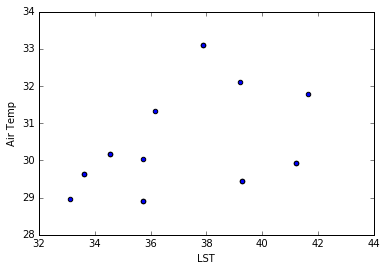

In [355]:
plt.scatter(satobsdf['LST'], satobsdf['temp'])
plt.xlabel('LST')
plt.ylabel('Air Temp')

In [356]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(satobsdf.drop(['lon','lat','Date','temp', 'id'],axis=1), 
                                                    satobsdf['temp'], test_size=0.30, random_state=101)
#Do the Regression
#X_train = df.drop(['longitude','latitude','time','temp'], axis=1)
#y_train = df['temp']
                  

from sklearn.linear_model import LinearRegression
lm = LinearRegression(normalize=True)

lm.fit(X_train,y_train)

predictions_train = lm.predict(X_train)
predictions_test = lm.predict(X_test)

ImportError: No module named model_selection

('MAE:', 4.0422104944686046)
('MSE:', 26.644173467160812)
('RMSE:', 5.161799440811393)


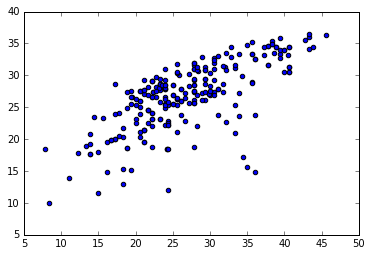

In [28]:
#Metrics for Training set
plt.scatter(y_train,predictions_train)
from sklearn import metrics
print('MAE:', metrics.mean_absolute_error(y_train, predictions_train))
print('MSE:', metrics.mean_squared_error(y_train, predictions_train))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_train, predictions_train)))

('MAE:', 5.0248910868420982)
('MSE:', 36.786258510700165)
('RMSE:', 6.0651676407746686)


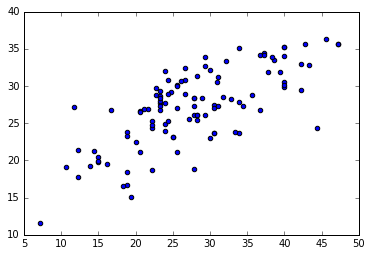

In [29]:
#Metrics for Test set
plt.scatter(y_test,predictions_test)
from sklearn import metrics
print('MAE:', metrics.mean_absolute_error(y_test, predictions_test))
print('MSE:', metrics.mean_squared_error(y_test, predictions_test))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions_test)))

In [31]:
#with elevation
print(lm.coef_)
print(lm.intercept_)

[  2.26853597e-01  -1.81088546e+01  -3.39203608e-03  -5.62309315e-02]
26.6847981872


In [32]:
X_train.head()

,LST,NDVI,elevation,impervious
339,19.210572,0.067237,71,26
434,3.087713,0.149250,1384,0
207,51.750492,0.067372,815,0
431,20.511744,0.268772,124,0
353,25.404771,0.179257,604,0
